# DATA VISUALIZATION

### Import necessary packages

In [1]:
import os
import numpy as np

import rasterio
from rasterio.windows import Window
from rasterio.plot import show
from matplotlib import pyplot as plt


from skimage.exposure import rescale_intensity
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:


# Obtenemos un objeto DatasetReader q tiene muchos atributos y métodos
img = rasterio.open(r'D:\tiles_training\tiles_masks\tiffs\tile_24000_0_novalues_blank.tif')
#img = rasterio.open('..\\..\\..\\datasets\\LC_2018_UTM_WGS84_31N_1m_12_Classes.tif')
#img = rasterio.open('..\\..\\..\\datasets\\12classes_downsampled_average.tif')


print(f"Metadata del objeto: {img.meta}")
print(f"Profile del objeto: {img.profile}")
print(f"Existen {img.count} bandas en este geotiff que es multiband, tiene varias bandas en el mismo archivo") 
print(f"El tamaño de la imagen es {img.width} x {img.height} píxeles")
print(f"El CRS (Coordinate Reference System) es {img.crs}")
print(f"Los bounds de la imagen son {img.bounds}")
print(f"La resolución de la imagen es {img.res}")
print(f"Los indexes de las bandas son {img.indexes}")
print(f"El nombre del fichero es {img.name}")
print(f"La descripción del fichero es {img.descriptions}")


Metadata del objeto: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 1000, 'height': 1000, 'count': 1, 'crs': CRS.from_epsg(32631), 'transform': Affine(10.0, 0.0, 480000.0,
       0.0, -10.0, 4780000.0)}
Profile del objeto: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 1000, 'height': 1000, 'count': 1, 'crs': CRS.from_epsg(32631), 'transform': Affine(10.0, 0.0, 480000.0,
       0.0, -10.0, 4780000.0), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
Existen 1 bandas en este geotiff que es multiband, tiene varias bandas en el mismo archivo
El tamaño de la imagen es 1000 x 1000 píxeles
El CRS (Coordinate Reference System) es EPSG:32631
Los bounds de la imagen son BoundingBox(left=480000.0, bottom=4770000.0, right=490000.0, top=4780000.0)
La resolución de la imagen es (10.0, 10.0)
Los indexes de las bandas son (1,)
El nombre del fichero es D:/tiles_training/tiles_masks/tiffs/tile_24000_0_novalues_blank.tif
La descripción del fichero es (None,)


In [12]:
raster_dirs = {
    'sentinel2april': '../../../datasets/S2_CAT_201804_UTM_WGS84_31N_10m.tif',
    'sentinel2august': '../../../datasets/S2_CAT_201808_UTM_WGS84_31N_10m.tif',
    'landcover': '../../../datasets/LC_2018_UTM_WGS84_31N_1m.tif',
}

In [3]:
def old_sentinel2_realcolor_original(image):
    image = image[2::-1]/1000 # magnification
    return rescale_intensity(
        image,
        in_range=(
            np.quantile(image, 0.01),
            np.quantile(image, 0.99),
        ),
    )

In [4]:
def old_sentinel2_realcolor(image):
    print(f"Image shape before slicing: {image.shape}")
    if image.shape[0] < 3:
        image = image[::-1]/1000 # reverse the entire array if it has fewer than 3 elements
    else:
        image = image[2::-1]/1000 # magnification
    return rescale_intensity(
        image,
        in_range=(
            np.quantile(image, 0.01),
            np.quantile(image, 0.99),
        ),
    )

In [5]:
def old_sentinel2_realcolor_esteve(image):
    # Segons pàgina https://fire.trainhub.eumetsat.int/docs/figure5678_Sentinel-2.html

    print(f"Image shape before: {image.shape}")
    if image.shape[0] < 3:
        image = image[::-1]/1000 # reverse the entire array if it has fewer than 3 elements
        print(f"Less than 3 bands")
    else:
        image = image[2::-1]/1000 # magnification
        print(f"More than 3 bands")
    
    # reordenar para RGB correcto 
    p2, p98 = np.percentile(image, (2,98))
    image = rescale_intensity(image, in_range=(p2, p98))
    print(f"Image shape after slicing: {image.shape}")
    return image

# Pickle files


## No Borders

In [7]:
import numpy as np
no_borders = np.load('../utils/no_borders_960.npy', allow_pickle=True)

print(f"Number of elements in no_borders: {len(no_borders)} de 960x960")

# Examino la distribució de les classes
lowest_pair = no_borders[np.argmin(no_borders[:, 0] + no_borders[:, 1])]
print(f"Lowest pair: {lowest_pair}")

highest_pair = no_borders[np.argmax(no_borders[:, 0] + no_borders[:, 1])]
print(f"highest pair: {highest_pair}")

# get some exmaples: 
#El centre
middle_index = len(no_borders) // 2
middle_pair = no_borders[middle_index]
print(f"Middle pair: {middle_pair}")

#els ultims 10
last_10_pairs = no_borders[-10:]
print("Last 10 pairs:", last_10_pairs)

# Es el qu tenen la X=76800
matching_pairs = no_borders[no_borders[:, 0] == 76800]
print("Es pot veure que van saltan de 960:", matching_pairs)


Number of elements in no_borders: 34040 de 960x960
Lowest pair: [70080 33600]
highest pair: [273600 144000]
Middle pair: [169920 147840]
Last 10 pairs: [[ 59520 287040]
 [ 44160 288000]
 [ 45120 288000]
 [ 46080 288000]
 [ 47040 288000]
 [ 48000 288000]
 [ 48960 288000]
 [ 46080 288960]
 [ 47040 288960]
 [ 48000 288960]]
Es pot veure que van saltan de 960: [[ 76800  35520]
 [ 76800  36480]
 [ 76800  37440]
 [ 76800  38400]
 [ 76800  39360]
 [ 76800  40320]
 [ 76800  41280]
 [ 76800  42240]
 [ 76800  43200]
 [ 76800  44160]
 [ 76800  45120]
 [ 76800  46080]
 [ 76800  47040]
 [ 76800  48000]
 [ 76800  48960]
 [ 76800  49920]
 [ 76800  50880]
 [ 76800  51840]
 [ 76800  52800]
 [ 76800  53760]
 [ 76800  54720]
 [ 76800  55680]
 [ 76800  56640]
 [ 76800  57600]
 [ 76800  58560]
 [ 76800  61440]
 [ 76800  62400]
 [ 76800  63360]
 [ 76800  64320]
 [ 76800  65280]
 [ 76800  66240]
 [ 76800  67200]
 [ 76800  68160]
 [ 76800  69120]
 [ 76800  70080]
 [ 76800  71040]
 [ 76800  72000]
 [ 76800  72

## Colormap and boundaries to plot correctly the landcover (groundtruth)

In [22]:
# només serveix per a mostrar landcover
with open('../utils/cmap_mcsc.pickle', 'rb') as f:
    cmap_mcsc = np.load(f, allow_pickle=True)
with open('../utils/norm_mcsc.pickle', 'rb') as f:
    norm_mcsc = np.load(f, allow_pickle=True)

# Mostrar tiles Sentinel-2 RGB en format RealColor

In [5]:
def get_sentinel2_realcolor_image(image, window):

    image = image[[2, 1, 0]] / 1000.0

    if window.col_off < 20000 and window.row_off < 9000:
        from skimage import exposure

        print("Apliquem blanc")
        #image_rescaled = rescale_intensity(image, in_range=(np.quantile(image, 0.01), np.quantile(image, 0.95)))
        # Apply contrast stretching
        image_rescaled = rescale_intensity(image, in_range=(np.quantile(image, 0.01), np.quantile(image, 0.99)))
        
    else:
        image_rescaled = rescale_intensity(image, in_range=(np.quantile(image, 0.01), np.quantile(image, 0.99)))
        print("No apliquem blanc")

    image_without_rescaling = image

    return image_rescaled, image_without_rescaling

### Mostrar imatges amb subplot

Apliquem blanc
Apliquem blanc


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.001..18.162].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.001..18.42].


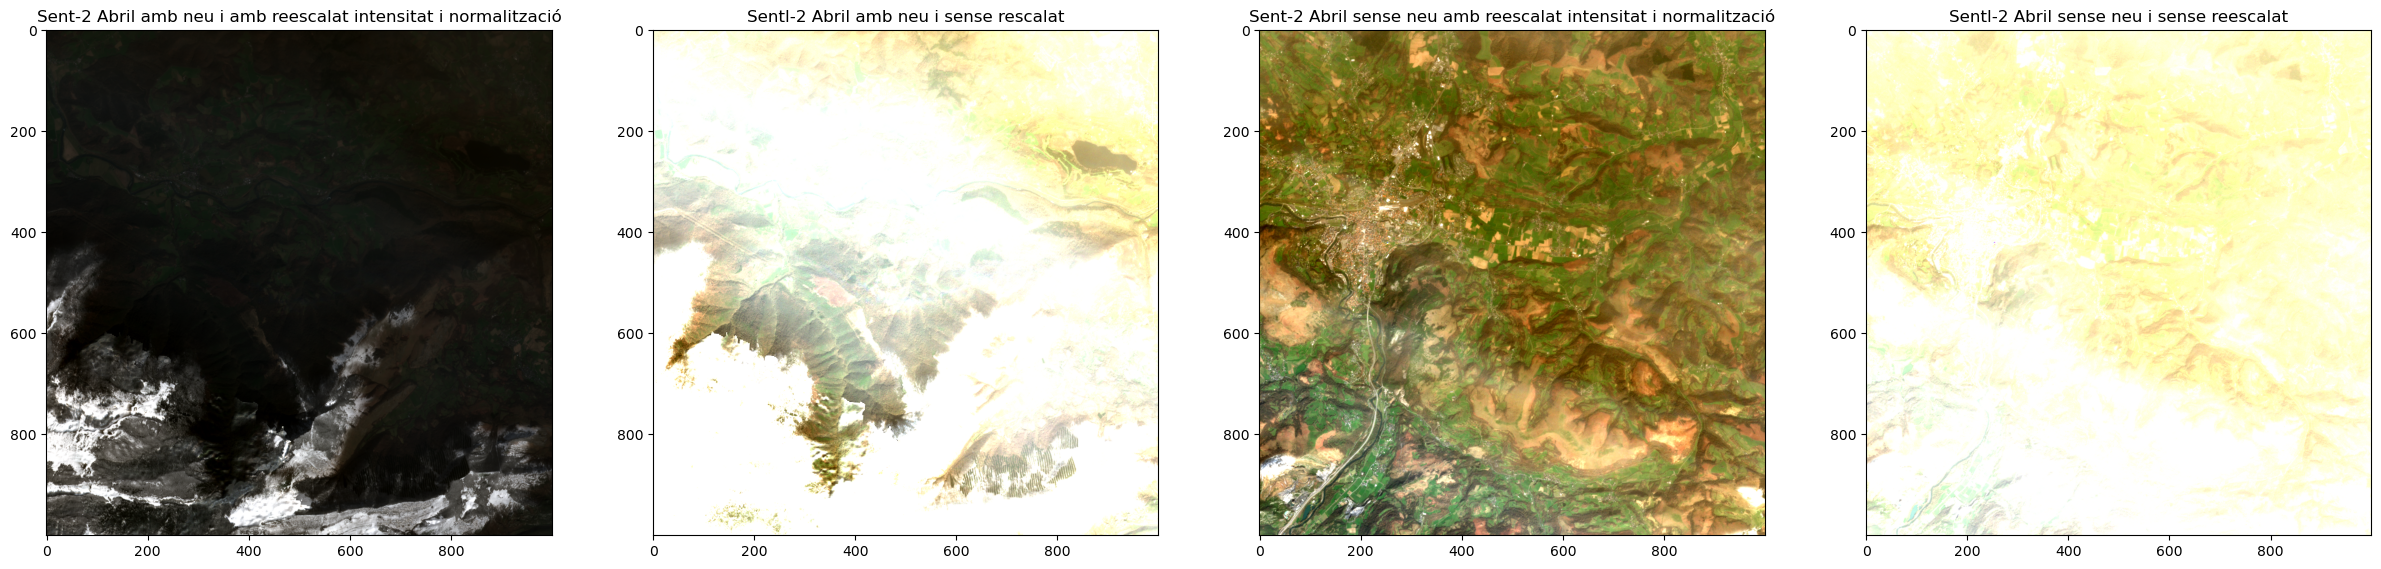

In [13]:
# Utilitzem 4 subplots per a mostrar les imatges
fig, axs = plt.subplots(1, 4, figsize=(30,10))
#fig.suptitle(f'Tile {tile}')
axs = axs.flatten()

tile = np.array([0, 0]) # que es el punt mig de Catalunya
window = Window(*tile, 1000, 1000)  # * és per a desempaquetar la llista i retornar coordinades X,Y

tile2 = np.array([1000, 0]) # que es el punt mig de Catalunya
window2 = Window(*tile2, 1000, 1000)  # * és per a desempaquetar la llista i retornar coordinades X,Y

with rasterio.open(raster_dirs['sentinel2april']) as src:
    pic = src.read([1,2,3], window=window)

with rasterio.open(raster_dirs['sentinel2april']) as src:
    pic2 = src.read([1,2,3], window=window2)

pic_r, pic_no_r = get_sentinel2_realcolor_image(pic, window)
pic_r = np.moveaxis(pic_r, 0, -1)
pic_no_r = np.moveaxis(pic_no_r, 0, -1)

pic_r2, pic_no_r2 = get_sentinel2_realcolor_image(pic2, window2)
pic_r2 = np.moveaxis(pic_r2, 0, -1)
pic_no_r2 = np.moveaxis(pic_no_r2, 0, -1)

axs[0].set_title('Sent-2 Abril amb neu i amb reescalat intensitat i normalització')
axs[0].imshow(pic_r)

axs[1].set_title('Sentl-2 Abril amb neu i sense rescalat')
axs[1].imshow(pic_no_r)

axs[2].set_title('Sent-2 Abril sense neu amb reescalat intensitat i normalització')
axs[2].imshow(pic_r2)

axs[3].set_title('Sentl-2 Abril sense neu i sense reescalat')
axs[3].imshow(pic_no_r2)

plt.show()


# Crear tiles a partir de imatges Sentinel-2

## Funcions per a crear tiles - EXTERNALITZAT AL FITXER crear_pngtiles_fromtiff.py


### Crear Tiles sense Normalització

In [26]:
def create_tiles_from_sentinel2_sense_norm(sentinel_file, output_dir):

    with rasterio.open(sentinel_file) as src:
        count = 0
        for x in range(0, src.width, 1000):
            for y in range(0, src.height, 1000):

                tile = np.array([x, y])
                print(f"Tile: {tile}")
                window = Window(x, y, 1000, 1000)
                # Llegeix les 3 bandes en la finestra indicada
                image = src.read([3, 2, 1], window=window)  # Read RGB bands

                # Convert to uint8 (scale values from the original range to 0-255)
                image = image.astype(np.float32)  # Convert to float to avoid overflow
                image = (image / image.max()) * 255  # Scale to 0-255
                image = image.astype(np.uint8)  # Convert back to uint8

                # Rearrange to (H, W, C) format for saving
                image = np.transpose(image, (1, 2, 0))

                plt.imsave(f"{output_dir}/tile_321_{x}_{y}.png", image)

                print(f"Tile saved at tile_{x}_{y}.png")
                count += 1

    print(f"Total: {count} i esperava 900")

In [28]:
create_tiles_from_sentinel2_sense_norm(raster_dirs['sentinel2august'], 'G:\\My Drive\\Personal\\PostgrauAIDL\\Proyecto-Grupo\\datasets\\tiles_no_norm\\agost')

Tile: [0 0]
Tile saved at tile_0_0.png
Tile: [   0 1000]
Tile saved at tile_0_1000.png
Tile: [   0 2000]
Tile saved at tile_0_2000.png
Tile: [   0 3000]
Tile saved at tile_0_3000.png
Tile: [   0 4000]
Tile saved at tile_0_4000.png
Tile: [   0 5000]
Tile saved at tile_0_5000.png
Tile: [   0 6000]
Tile saved at tile_0_6000.png
Tile: [   0 7000]
Tile saved at tile_0_7000.png
Tile: [   0 8000]
Tile saved at tile_0_8000.png
Tile: [   0 9000]
Tile saved at tile_0_9000.png
Tile: [    0 10000]
Tile saved at tile_0_10000.png
Tile: [    0 11000]
Tile saved at tile_0_11000.png
Tile: [    0 12000]
Tile saved at tile_0_12000.png
Tile: [    0 13000]
Tile saved at tile_0_13000.png
Tile: [    0 14000]
Tile saved at tile_0_14000.png
Tile: [    0 15000]
Tile saved at tile_0_15000.png
Tile: [    0 16000]
Tile saved at tile_0_16000.png
Tile: [    0 17000]
Tile saved at tile_0_17000.png
Tile: [    0 18000]
Tile saved at tile_0_18000.png
Tile: [    0 19000]
Tile saved at tile_0_19000.png
Tile: [    0 20000]

### Crear tiles amb Normalització (cal ajustar la normalització)

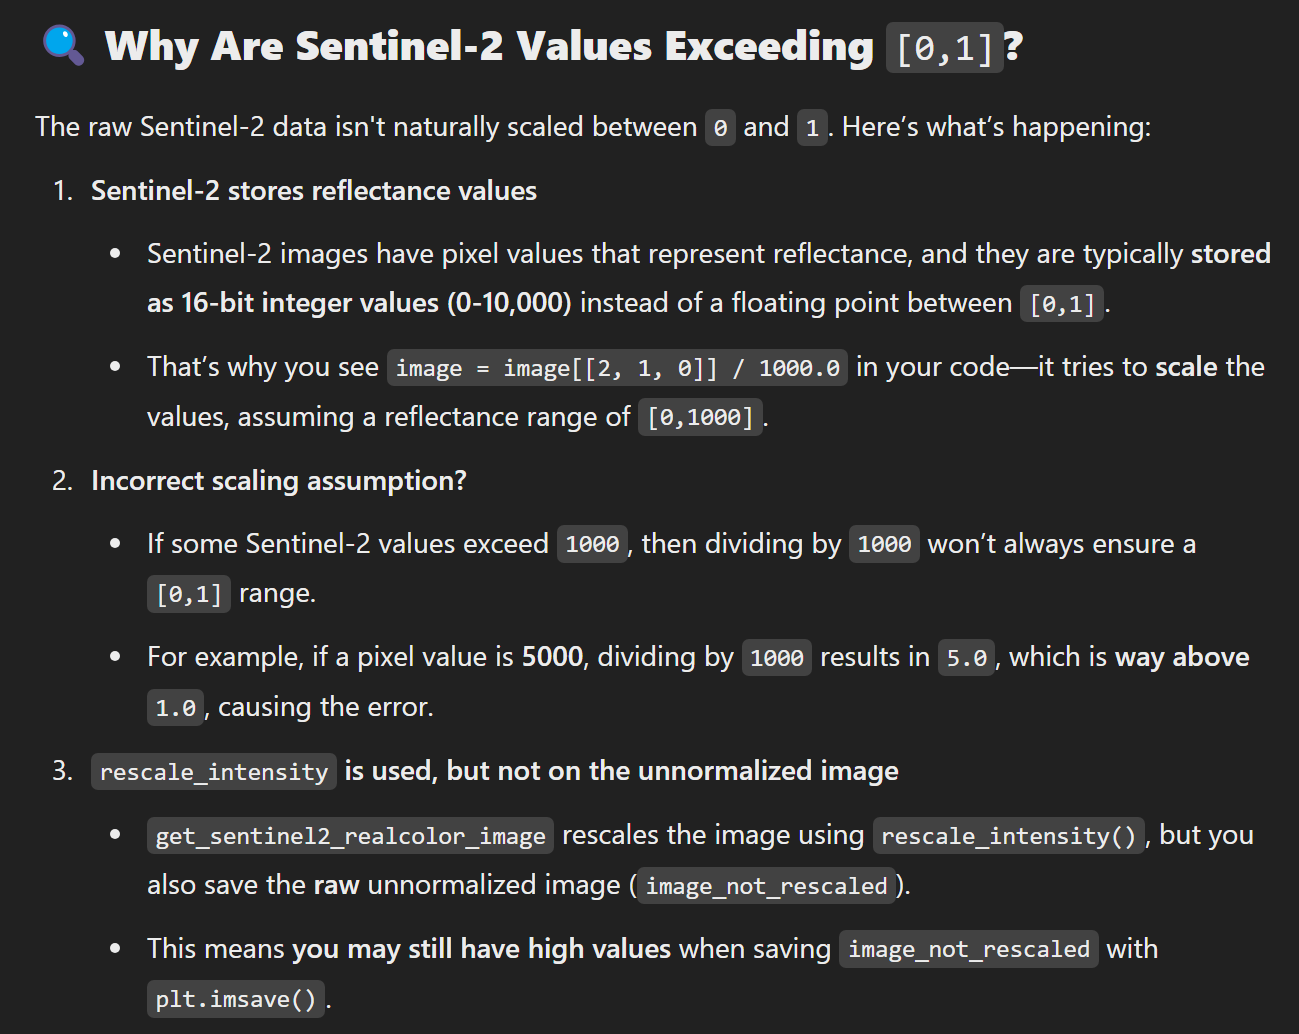

In [125]:
# Ensure the output directory exists

def create_tiles_from_sentinel2_norm(sentinel_file, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    with rasterio.open(sentinel_file) as src:
        img_width, img_height = src.width, src.height #dimensions of the sentinel-2 image
        tile_size = 1000
        count = 0
        
        # Loop through the entire image, creating non-overlapping 1000x1000 tiles
        for x in range(0, img_width, tile_size):
            for y in range(0, img_height, tile_size):
                # Define a window for the current tile
                window = Window(x, y, tile_size, tile_size)

                # Read the RGB bands 
                try:
                    image = src.read([1, 2, 3], window=window)
                    if image.size == 0:
                        print(f"Skipping empty tile at ({x}, {y})")
                        continue
                except Exception as e:
                    print(f"Error reading tile at ({x}, {y}): {e}")
                    continue

                # Convert to Realcolor using the function defined above 
                image_rescaled, _ = get_sentinel2_realcolor_image(image, window)

                # As the first dimension is the color channel, the function imsave is expecting a different order
                image_rescaled = np.moveaxis(image_rescaled, 0, -1)  # Adjust channel order for saving

                # Save the image 
                filepath = os.path.join(output_dir, f"tile_{x}_{y}.png")
                plt.imsave(filepath, image_rescaled)

                count += 1
                print(f"Saved image {count}: for {x} - {y}")
    
    print(f"Total images saved: {count} and expected 900")


In [19]:
# Call the function to generate all 1000x1000 tiles
create_tiles_from_sentinel2_norm(raster_dirs['sentinel2august'], 'D:\\tiles_tots\\tiles_1000_normalitzats')

Image shape: (3, 1000, 1000)
Saved image 1: tile_0_0.png
Image shape: (3, 1000, 1000)
Saved image 2: tile_0_1000.png
Image shape: (3, 1000, 1000)
Saved image 3: tile_0_2000.png
Image shape: (3, 1000, 1000)
Saved image 4: tile_0_3000.png
Image shape: (3, 1000, 1000)
Saved image 5: tile_0_4000.png
Image shape: (3, 1000, 1000)
Saved image 6: tile_0_5000.png
Image shape: (3, 1000, 1000)
Saved image 7: tile_0_6000.png
Image shape: (3, 1000, 1000)
Saved image 8: tile_0_7000.png
Image shape: (3, 1000, 1000)
Saved image 9: tile_0_8000.png
Image shape: (3, 1000, 1000)
Saved image 10: tile_0_9000.png
Image shape: (3, 1000, 1000)
Saved image 11: tile_0_10000.png
Image shape: (3, 1000, 1000)
Saved image 12: tile_0_11000.png
Image shape: (3, 1000, 1000)
Saved image 13: tile_0_12000.png
Image shape: (3, 1000, 1000)
Saved image 14: tile_0_13000.png
Image shape: (3, 1000, 1000)
Saved image 15: tile_0_14000.png
Image shape: (3, 1000, 1000)
Saved image 16: tile_0_15000.png
Image shape: (3, 1000, 1000)
S

## Funció per a juntar tots els tiles en una imatge RealColor - EXTERNALITZAT AL FITXER combinar_tiles_PNG.py

I així veure com queda

In [15]:
def combine_tiles_png_nofunciona(fitxer_complert, filename_format, output_dir):
    
    img_width, img_height = 30000, 30000
    full_image = torch.zeros((img_height, img_width, 3), dtype=torch.float32, device='cuda')

    tile_size = 1000
    for x in range(0, img_width, tile_size):
        for y in range(0, img_height, tile_size):
    
            filename = f"{filename_format}_{x}_{y}.png"
            filepath = os.path.join(output_dir, filename)
            if os.path.exists(filepath):
                tile_image = plt.imread(filepath)
                # Ensure the image has only 3 channels (RGB)
                if tile_image.shape[-1] == 4:
                    tile_image = tile_image[..., :3]
                tile_image_tensor = torch.tensor(tile_image, dtype=torch.float32, device='cuda')
                full_image[y:y+tile_size, x:x+tile_size] = tile_image_tensor
                print(f"Added tile ({x}, {y}) to the composite image")
            else:
                print(f"Tile missing: {filename}")

    # Resize using PyTorch on GPU to fit a 4K width (3840 pixels wide)
    full_image_resized = torch.nn.functional.interpolate(   
        full_image.permute(2, 0, 1).unsqueeze(0),  # Convert to [C, H, W]
        size=(int(3840 * (img_height / img_width)), 3840),
        mode='bilinear',
        align_corners=False
    ).squeeze().permute(1, 2, 0).cpu().numpy()

    plt.imsave(os.path.join(output_dir, f'{fitxer_complert}.png'), full_image_resized)

    print("Imatge de catalunya generada : " + os.path.join(output_dir, f'{fitxer_complert}.png'))

In [20]:
import re
from PIL import Image

def get_tile_coordinates(filename):
    match = re.match(r'tile_rescal_(\d+)_(\d+)\.png', filename) # 321 perquè és la combinació de 3, 2 1 de Sentinel q he extret si és diferent, cal canviar
    if match:
        return int(match.group(1)), int(match.group(2))
    return None

def merge_tiles(tile_dir, output_file):
    tiles = []
    
    # Scan directory for tile images
    for filename in os.listdir(tile_dir):
        coords = get_tile_coordinates(filename)
        if coords:
            tiles.append((coords, filename))
    
    if not tiles:
        print("No tiles found!")
        return
    
    # Determine grid size
    max_x = max(tile[0][0] for tile in tiles)
    max_y = max(tile[0][1] for tile in tiles)
    
    # Compute final image size
    width = (max_x // 1000 + 1) * 1000
    height = (max_y // 1000 + 1) * 1000
    
    print(f"Merging {len(tiles)} tiles into {width}x{height} image...")
    
    # Create blank canvas
    merged_image = Image.new('RGB', (width, height))
    
    # Place tiles on the canvas with a counter
    counter = 0
    for (x, y), filename in tiles:
        tile_path = os.path.join(tile_dir, filename)
        tile_image = Image.open(tile_path)
        merged_image.paste(tile_image, (x, y))
        counter += 1
        print(f"Processed {counter}/{len(tiles)} tiles")
    
    # Save merged image with optimized speed
    merged_image.save(output_file, compress_level=0)
    print(f"Merged image saved as {output_file}")

In [21]:
#combine_tiles_png("cat-2010808-321-sense-normalitzacio.png", "tile_321",  "d:\\tiles_tots\\tiles_no_norm\\agost")
#combine_tiles_png("cat-2010804-321-sense-normalitzacio.png", "d:\\tiles_tots\\tiles_no_norm\\abril")
merge_tiles("D:\\tiles_tots", "d:\\tiles_tots\\agost_rescalat.png") # Tarda uns 90'' 

Merging 900 tiles into 30000x30000 image...
Processed 1/900 tiles
Processed 2/900 tiles
Processed 3/900 tiles
Processed 4/900 tiles
Processed 5/900 tiles
Processed 6/900 tiles
Processed 7/900 tiles
Processed 8/900 tiles
Processed 9/900 tiles
Processed 10/900 tiles
Processed 11/900 tiles
Processed 12/900 tiles
Processed 13/900 tiles
Processed 14/900 tiles
Processed 15/900 tiles
Processed 16/900 tiles
Processed 17/900 tiles
Processed 18/900 tiles
Processed 19/900 tiles
Processed 20/900 tiles
Processed 21/900 tiles
Processed 22/900 tiles
Processed 23/900 tiles
Processed 24/900 tiles
Processed 25/900 tiles
Processed 26/900 tiles
Processed 27/900 tiles
Processed 28/900 tiles
Processed 29/900 tiles
Processed 30/900 tiles
Processed 31/900 tiles
Processed 32/900 tiles
Processed 33/900 tiles
Processed 34/900 tiles
Processed 35/900 tiles
Processed 36/900 tiles
Processed 37/900 tiles
Processed 38/900 tiles
Processed 39/900 tiles
Processed 40/900 tiles
Processed 41/900 tiles
Processed 42/900 tiles

# Analisi del fitxer de 12 classes

In [2]:
classes_12 = {
 'Herbaceous crops': 1,
 'Woody crops': 2,
 'Forest': 3,
 'Scrub, meadows and grasslands': 4,
 'Bare soil': 5,
 'Urban area': 6,
 'Isolated urban areas': 7,
 'Green areas': 8,
 'Industrial, commercial and leisure areas': 9,
 'Mining or landfills': 10,
 'Transport network': 11,
 'Watercourses and water bodies': 12
 }

In [4]:

# Path to the groundtruth file
groundtruth_file = r'D:\aidl_projecte\datasets\LC_2018_UTM_WGS84_31N_1m_12_Classes_downsampled30x30_mode.tif'
#groundtruth_file = 'G:\\My Drive\\Personal\\PostgrauAIDL\\Proyecto-Grupo\\datasets\\12classes_downsampled_to_30k_30k.tif'
#groundtruth_file = 'G:\\My Drive\\Personal\\PostgrauAIDL\\Proyecto-Grupo\\datasets\\LC_2018_UTM_WGS84_31N_1m_12_Classes_downsampled30x30_mode.tif'
#groundtruth_file = 'D:\\tiles_training\\tiles_masks\\tiffs\\tile_7000_15000.tif'

# Open the file and read a portion 
with rasterio.open(groundtruth_file) as src:
    small_window = rasterio.windows.Window(24000, 0, 1000, 1000)
    values = src.read(1, window=small_window)
    print(f"Shape: {values.shape}")

# Print the first values
print("Values:")
print(values)


Shape: (1000, 1000)
Values:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [25]:
# Quin es el primer pixel q no té classe = 0

import rasterio
import torch

# Path to the groundtruth file
#groundtruth_file = '..\\..\\..\\datasets\\LC_2018_UTM_WGS84_31N_1m_12_Classes.tif'
groundtruth_file = r'D:\tiles_training\tiles_masks\tiffs\tile_24000_7000.tif'

print(f"Recorrem els blocks a la cerca del primer pixel que no tingui classe=0")

with rasterio.open(groundtruth_file) as src:
    block_size = 1000 # Després de fer proves, per a la meva GPU de 8GB, aquest és el màxim que puc llegir
    print(f"Tamany de block: {block_size}x{block_size}")
    found = False
    block_number = 0
    for j in range(0, src.height, block_size):
        for i in range(0, src.width, block_size):
            block_number += 1
            # Read a block of pixels
            window = rasterio.windows.Window(i, j, block_size, block_size)
            block = src.read(1, window=window)

            # Transfer block data to GPU and convert to tensor
            block_tensor = torch.tensor(block, device='cuda')
            no_data_value = src.nodata if src.nodata is not None else 0

            # Identify non-zero pixels using GPU
            valid_pixels = (block_tensor != no_data_value) & (block_tensor != 0)
            if torch.any(valid_pixels):
                # Find the first non-zero pixel using GPU
                non_zero_indices = torch.nonzero(valid_pixels, as_tuple=False)[0]  # Return the first match directly
                y, x = non_zero_indices.tolist()
                print(f"El 1r pixel q no és zero està en el block: {block_number} en el pixel: ({i + x}, {j + y}) i és de la classe {block[y, x]}")
                
                absolute_x = block_number*block_size + x + i
                absolute_y = block_number*block_size + y + j
                print(f"Per tant, el 1r pixel q no té classe 0 està en la posició absoluta: ({absolute_x}, {absolute_y})")
                found = True
                break
        if found:
            break

# 

Recorrem els blocks a la cerca del primer pixel que no tingui classe=0
Tamany de block: 1000x1000
El 1r pixel q no és zero està en el block: 1 en el pixel: (931, 829) i és de la classe 3
Per tant, el 1r pixel q no té classe 0 està en la posició absoluta: (1931, 1829)


# Histograma de un geotiff

Imatge de 30000x30000 en titles de: 1000x1000...
Processed chunk at (0, 0) -> Histogram updated.
Processed chunk at (1000, 0) -> Histogram updated.
Processed chunk at (2000, 0) -> Histogram updated.
Processed chunk at (3000, 0) -> Histogram updated.
Processed chunk at (4000, 0) -> Histogram updated.
Processed chunk at (5000, 0) -> Histogram updated.
Processed chunk at (6000, 0) -> Histogram updated.
Processed chunk at (7000, 0) -> Histogram updated.
Processed chunk at (8000, 0) -> Histogram updated.
Processed chunk at (9000, 0) -> Histogram updated.
Processed chunk at (10000, 0) -> Histogram updated.
Processed chunk at (11000, 0) -> Histogram updated.
Processed chunk at (12000, 0) -> Histogram updated.
Processed chunk at (13000, 0) -> Histogram updated.
Processed chunk at (14000, 0) -> Histogram updated.
Processed chunk at (15000, 0) -> Histogram updated.
Processed chunk at (16000, 0) -> Histogram updated.
Processed chunk at (17000, 0) -> Histogram updated.
Processed chunk at (18000, 0

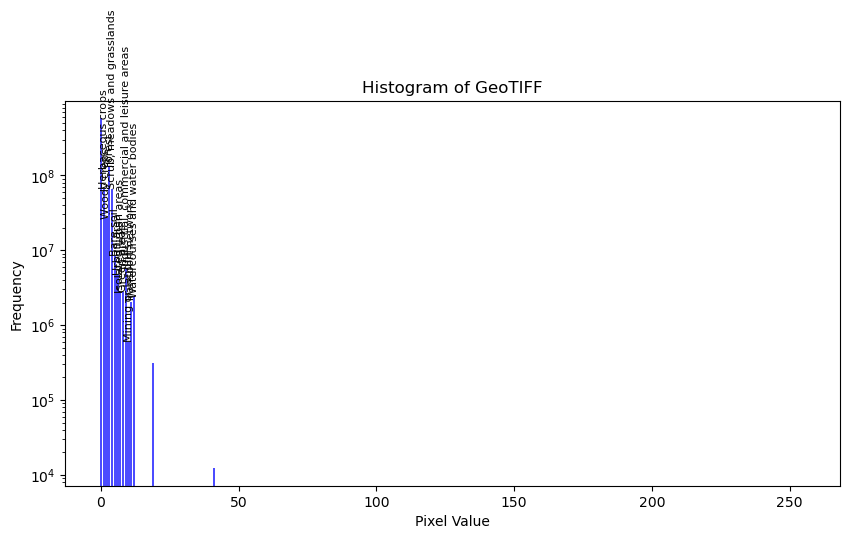

In [17]:
# Distribució de classes en un block
# partim el fitxer 

import rasterio
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# Path to the groundtruth file
groundtruth_file = r'D:\aidl_projecte\datasets\LC_2018_UTM_WGS84_31N_1m_12_Classes_downsampled30x30_mode.tif'
#groundtruth_file = r'D:\aidl_projecte\datasets\LC_2018_UTM_WGS84_31N_1m_12_Classes.tif'
#groundtruth_file = '..\\..\\..\\datasets\\LC_2018_UTM_WGS84_31N_1m.tif'

histogram = None  # Will hold the histogram data

chunk_size = 1000  # 30000 es solo para el de 12 clases de 300kx300k, para el resto 1000x1000 mejor
with rasterio.open(groundtruth_file) as src:
    width, height = src.width, src.height
    dtype = src.dtypes[0] #Banda

    print(f"Imatge de {width}x{height} en titles de: {chunk_size}x{chunk_size}...")

    for y in range(0, height, chunk_size):
        for x in range(0, width, chunk_size):
            window = rasterio.windows.Window(x, y, min(chunk_size, width - x), min(chunk_size, height - y))
            data = src.read(1, window=window).flatten()

            # Update histogram
            if histogram is None:
                histogram = np.bincount(data, minlength=256)  # Assuming 8-bit depth (0-255)
            else:
                histogram += np.bincount(data, minlength=256)

            print(f"Processed chunk at ({x}, {y}) -> Histogram updated.")

# Create a mapping from class value to class name
class_names = {v: k for k, v in classes_12.items()}

# Plot the histogram
plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(histogram)), histogram, color='blue', alpha=0.7)

# Add class names as labels
for i, bar in enumerate(bars):
    if i in class_names:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), class_names[i], ha='center', va='bottom', rotation=90, fontsize=8)

plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.title("Histogram of GeoTIFF")
plt.yscale('log')  # Log scale for better visualization of distribution
plt.show()





In [15]:
# Creem un fitxer de 30000x30000 a partir de les 12 clases, com si fos una convulució
# No funciona, tarda hores degut a que el fitxer és enorme

import rasterio
import torch
import numpy as np
from rasterio.windows import Window

# Path to the groundtruth file
groundtruth_file = '..\\..\\..\\datasets\\LC_2018_UTM_WGS84_31N_1m_12_Classes.tif'
output_file = '..\\..\\..\\datasets\\LC_2018_downsampled.tif'

# Set the block size for batch processing
block_size = 1000  # Process larger chunks at once

# Open the file and prepare to create the downsampled version
with rasterio.open(groundtruth_file) as src:
    # Calculate the dimensions for the downsampled image
    downsampled_height = src.height // 10
    downsampled_width = src.width // 10

    # Prepare metadata for the output file
    profile = src.profile
    profile.update({
        'height': downsampled_height,
        'width': downsampled_width,
        'dtype': 'uint8',
        'compress': 'lzw'
    })

    # Create the output file
    with rasterio.open(output_file, 'w', **profile) as dst:
        # Process the image block-wise
        total_steps = (src.height // block_size) * (src.width // block_size)
        step = 0
        for y in range(0, src.height, block_size):
            for x in range(0, src.width, block_size):
                step += 1
                print(f"Processing step {step}/{total_steps}: Block starting at ({x}, {y})")

                # Ensure the block doesn't exceed image bounds
                win_height = min(block_size, src.height - y)
                win_width = min(block_size, src.width - x)

                # Read a larger block for batch processing
                window = Window(x, y, win_width, win_height)
                block = src.read(1, window=window)

                # Transfer data to GPU and reshape for batch reduction
                block_tensor = torch.tensor(block, dtype=torch.float32, device='cuda')
                block_tensor = block_tensor.unfold(0, 10, 10).unfold(1, 10, 10)

                # Flatten and compute the mean while ignoring NoData values
                results = torch.zeros((win_height // 10, win_width // 10), device='cuda')
                for row in range(results.shape[0]):
                    for col in range(results.shape[1]):
                        sub_block = block_tensor[row, col].flatten()
                        valid_pixels = sub_block[sub_block != 0]
                        results[row, col] = torch.round(valid_pixels.mean()).clamp(1, 12) if valid_pixels.numel() > 0 else 0

                # Move results back to CPU and write to file
                results_cpu = results.cpu().numpy().astype(np.uint8)
                dst.write(results_cpu, window=Window(x // 10, y // 10, results.shape[1], results.shape[0]), indexes=1)

print("Downsampling complete! The downsampled file has been saved.")



Processing step 1/90000: Block starting at (0, 0)
Processing step 2/90000: Block starting at (1000, 0)
Processing step 3/90000: Block starting at (2000, 0)
Processing step 4/90000: Block starting at (3000, 0)
Processing step 5/90000: Block starting at (4000, 0)
Processing step 6/90000: Block starting at (5000, 0)
Processing step 7/90000: Block starting at (6000, 0)
Processing step 8/90000: Block starting at (7000, 0)
Processing step 9/90000: Block starting at (8000, 0)
Processing step 10/90000: Block starting at (9000, 0)
Processing step 11/90000: Block starting at (10000, 0)
Processing step 12/90000: Block starting at (11000, 0)
Processing step 13/90000: Block starting at (12000, 0)
Processing step 14/90000: Block starting at (13000, 0)
Processing step 15/90000: Block starting at (14000, 0)
Processing step 16/90000: Block starting at (15000, 0)
Processing step 17/90000: Block starting at (16000, 0)
Processing step 18/90000: Block starting at (17000, 0)
Processing step 19/90000: Block 

KeyboardInterrupt: 

# Data preparation to train a neural network

### Convert numpy arrays into torch tensors

In [26]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        tile, orthophoto, orthophotoIR, chm, sentinel2april, sentinel2august, landcover = \
        sample['tile'], sample['sentinel2april'], sample['sentinel2august'], sample['landcover']
        
        sentinel2april = sentinel2april.astype(np.float32)
        sentinel2august = sentinel2august.astype(np.float32)
        
        return {
            'tile': tile,
            'sentinel2april': torch.from_numpy(sentinel2april), 
            'sentinel2august': torch.from_numpy(sentinel2august),
            'landcover': torch.from_numpy(landcover-1) # -1 to start in class 0, dataset starts in class 1
        }

It would be also interesting to create a new transformation in order to normalize the tensors.

We create the dataset with the desired shape for each tile. In this case we have some images of 1m and 10m resolution. We could also more images from the dataset.

In [14]:

from torch.utils.data import Dataset

class CatalanDataset(Dataset):
    def __init__(self, tiles_list, raster_dirs, shape=960, transform=None):
        self.tiles_list = tiles_list
        self.raster_dirs = raster_dirs
        self.transform = transform
        self.shape = shape

    def __len__(self):
        return len(self.tiles_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
            
        window_1m = Window(*self.tiles_list[idx], self.shape, self.shape)
        window_10m = Window(*self.tiles_list[idx] // 10, self.shape//10, self.shape//10)
        
        with rasterio.open(self.raster_dirs['landcover']) as src:
            raster_landcover = src.read(window=window_1m) # (1,shape,shape) uint8
            
        with rasterio.open(self.raster_dirs['sentinel2april']) as src:
            raster_sentinel2april = src.read([1,2,3,4,5,6,7,8,9,10], window=window_10m) # (10,shape,shape) uint16
            
        with rasterio.open(self.raster_dirs['sentinel2april']) as src:
            raster_sentinel2august = src.read([1,2,3,4,5,6,7,8,9,10], window=window_10m) # (10,shape,shape) uint16
            
        with rasterio.open(self.raster_dirs['chm']) as src:
            raster_chm = src.read(window=window_10m)  # (1,shape,shape) float32
            
        sample = {
            'tile': idx, 
            'sentinel2april': raster_sentinel2april,
            'sentinel2august': raster_sentinel2august,
            'landcover': raster_landcover
        }
        

        if self.transform:
            sample = self.transform(sample)

        return sample

Processing step 1/90000: Block starting at (0, 0)
Processing step 2/90000: Block starting at (1000, 0)


KeyboardInterrupt: 

In [28]:
catalan_dataset_train = CatalanDataset(no_borders, raster_dirs, transform=transforms.Compose([ToTensor()]))

Dataloader used to train in paralel as much tiles as wanted. It is recommended to increase num_workers to speed up the process.

In [11]:
data = next(iter(train_loader))